In [2]:
!pip install tensorflow==2.3.1
!pip install tensorflow-gpu==2.3.1
!pip install keras==2.4.3
!pip install keras-vggface==0.6
!pip install keras_applications==1.0.8
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 KB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 94.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast

In [3]:
from keras_vggface.vggface import VGGFace
from keras.models import Sequential 
from keras.layers import Activation, Dense
from keras.models import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import CSVLogger,EarlyStopping
from keras_vggface.utils import decode_predictions
import itertools

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/My Drive/Project'

#!unzip "/content/drive/My Drive/1. IIITD_80_10_10" -d "/content/"
!unzip "/content/drive/My Drive/Project/Dataset" -d "/content/"

Mounted at /content/drive
/content/drive/My Drive/Project
Archive:  /content/drive/My Drive/Project/Dataset.zip
   creating: /content/Vgg_Dataset/test/
   creating: /content/Vgg_Dataset/test/C1/
  inflating: /content/Vgg_Dataset/test/C1/dr_0_250.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_1_3372.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_10_7640.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_11_4356.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_12_9310.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_15_1218.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_19_7164.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_21_2733.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_21_7228.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_22_2364.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_23_5437.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_24_6963.jpg  
  inflating: /content/Vgg_Dataset/test/C1/dr_26_9205.jpg  
  inflating: /content/Vgg_Dataset/test/C1

In [5]:
def load_dataset(dataset_Path,batch_size):


  train_data_dir='/content/Vgg_Dataset/train'
  test_data_dir = '/content/Vgg_Dataset/test'
  val_data_dir = '/content/Vgg_Dataset/val'



  train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   rotation_range=40,
                                   
                                   zoom_range=0.2,
                                  
                                   horizontal_flip=True)

  train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(224,224),
                        batch_size=batch_size,
                        class_mode='categorical')

  print(train_generator.classes)
  print(train_generator.class_indices)


  val_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                     rotation_range=40,   
                                   zoom_range=0.2,
                                   horizontal_flip=True)
  val_generator = val_datagen.flow_from_directory(
                        val_data_dir,
                      
                        target_size=(224,224),
                        batch_size=batch_size,
                        class_mode='categorical')


  print(val_generator.classes)
  print(val_generator.class_indices)





  test_datagen = ImageDataGenerator(rescale=1./255)

  test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(224,224),
                        batch_size=batch_size,
                        shuffle=False,
                        seed=42,
                        class_mode='categorical')


  print(test_generator.classes)
  print(test_generator.class_indices)
  return train_generator,val_generator,test_generator


In [6]:
def create_model():
  vggface = VGGFace(model='vgg16')
  vggface.summary()
  return vggface


In [7]:
def fine_tune(old_model):

  inp = old_model.input     # make a reference to VGG's input layer
  num_classes=8

  new_classification_layer=Dense(num_classes,activation='softmax')
  new_model=Sequential()

  # connect the above new layer to the second to last layer in VGG, and make a reference to it
  out = new_classification_layer(old_model.layers[-2].output)

# create a new network between inp and out
  model_new = Model(inp, out)

  # make all layers untrainable by freezing weights 
  for l, layer in enumerate(model_new.layers):
    layer.trainable = False
  # Enable the last three dense layers for  training
  for l, layer in enumerate(model_new.layers[-6:]):
    layer.trainable = True

  model_new.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.RMSprop(lr=1e-5),
                    metrics=['accuracy'])

  
  return model_new

In [10]:
def train_fine_tuned_vgg16_model(model_new, load_weight,train_data,val_data,batch_size,checkpoint_path):

  #%load_ext tensorboard
  #log_dir = "/content/drive/MyDrive/ICDFD_VGG/log_imfdb_dense/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  #%tensorboard --logdir '/content/drive/MyDrive/ICDFD_VGG/log_imfdb_dense/'
  #log_dir = "/content/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  #%tensorboard --logdir '/content/logs/'
  #Model loading
  if load_weight==True:
    model_new.load_weights("/content/drive/MyDrive/Project/logs/Reva_Vgg-0003.h5")  # load the latest model and change the checkpoint name and retrain where u left off

  # Create a callback that saves the model's weights
  cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 mode='min',
                                                 period=1)
  

  csv_logger=CSVLogger('/content/drive/My Drive/Project/Reva_VGGFace_v1.csv',separator=',',append=True)

  steps_per_epoch =  np.floor(train_data.n / batch_size)     # total number of images in train /batch size
  validation_steps =  np.floor(val_data.n / batch_size)     # total number of images in test /batch size

  nepochs = 1   # earlier 150
   
 


  early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)  #erlier val_loss
  
  #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  model_new.fit_generator(train_data,
                          epochs=nepochs,      #steps_per_epoch=steps_per_epoch,
                          validation_data=val_data,
                          validation_steps=validation_steps,
                          callbacks=[cp_callback,early_stop,csv_logger])#,cp_callback,tensorboard_callback])



  model_new.save('Reva_Vgg_Model_V1.h5')
  model_new.save_weights('Reva_Vgg_finetuned_weights_60_20_20_V1.h5')
 # np.save('/content/drive/My Drive/my_history_Cov_unfrezzed_.npy',model_new.history)
  return model_new

In [11]:
model=create_model()
model_new=fine_tune(model)
model_new.summary()

580075520/580070376 [==============================] - 21s 0us/step
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
___________________________________________________

In [12]:
batch_size=50
dataset_path="/content/"
root_dir="/content/drive/My Drive/Project"

train_data,val_data,test_data=load_dataset(dataset_path,batch_size)
for names in model_new.layers:
  if names.trainable==True:
    print(names.name)
load_epoch_weights=True  # if True change the below checkpoint name before training.
checkpoint_path = root_dir+"/logs/dar_Reva_Vgg-{epoch:04d}.h5"     #earlier
#checkpoint_path = dataset_path+"/logs/ICDFD_mtcnn_VGGFace_new-{epoch:04d}.h5"

Found 1607 images belonging to 8 classes.
[0 0 0 ... 7 7 7]
{'C1': 0, 'C2': 1, 'C3': 2, 'C4': 3, 'C5': 4, 'C6': 5, 'C7': 6, 'C8': 7}
Found 196 images belonging to 8 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7]
{'C1': 0, 'C2': 1, 'C3': 2, 'C4': 3, 'C5': 4, 'C6': 5, 'C7': 6, 'C8': 7}
Found 209 images belonging to 8 classes.
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 

In [ ]:
model_new=train_fine_tuned_vgg16_model(model_new,load_epoch_weights,train_data,val_data,batch_size,checkpoint_path)

Instructions for updating:
Please use Model.fit, which supports generators.


33/33 [==============================] - 1038s 31s/step - loss: 0.0207 - accuracy: 0.9956 - val_loss: 0.0727 - val_accuracy: 0.9667


In [13]:
plt.plot(model_new.history.history['loss'],label='Train_loss')
plt.plot(model_new.history.history['val_loss'],label='Val_loss')
plt.legend()
plt.show()

AttributeError: ignored

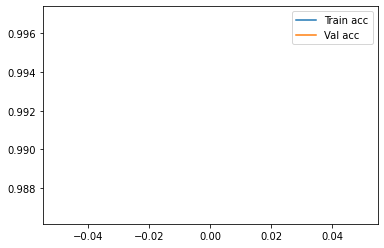

In [ ]:
plt.plot(model_new.history.history['accuracy'],label='Train acc')
plt.plot(model_new.history.history['val_accuracy'],label='Val acc')
plt.legend()
plt.show()

In [15]:
filenames = test_data.filenames
nb_samples = len(filenames)

predict = model_new.predict_generator(test_data,steps = nb_samples,verbose=1)
print(len(predict))
pred = np.argmax(predict,axis=1) 


  5/209 [..............................] - ETA: 1:01:36

  5/209 [..............................] - 91s 18s/step
209


In [16]:
loss,acc=model_new.evaluate_generator(test_data)
print(loss)
print(acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.


2.077754497528076
0.15311004221439362


In [18]:
from sklearn import metrics
class_name=test_data.classes
#y_compare = np.argmax(class_name,axis=1) 
score = metrics.accuracy_score(class_name, pred)
print("Accuracy score: {}".format(score))

ImportError: ignored

In [8]:
from sklearn.externals import joblib
joblib.dump(score,'FR_model.pkl')
print('System is trained for face recognition sucessfully')

ImportError: ignored

THE BELOW CODE IS USED TO LOAD THE MODEL AND TEST THE ACCURACY


In [ ]:
from keras.models import load_model
classifier = load_model('/content/drive/My Drive/Project/logs/Reva_Vgg-0001.h5')

OSError: ignored

In [ ]:
classifier.summary()

In [ ]:
dataset_path="/content/"
train_data,val_data,test_data=load_dataset(dataset_path,256)

In [ ]:
loss,acc=classifier.evaluate_generator(test_data)
print(loss)
print(acc)

0.7551330327987671
0.8113448023796082


In [ ]:
true_classes = test_data.classes
class_indices = train_data.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = classifier.predict(test_data)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 81.13%


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_classes, vgg_pred_classes)

array([[15,  0,  0, ...,  0,  0,  0],
       [ 0, 19,  0, ...,  0,  0,  0],
       [ 0,  0, 12, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 22,  0,  0],
       [ 0,  0,  0, ...,  0,  3,  0],
       [ 1,  0,  0, ...,  0,  0, 12]])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(true_classes, vgg_pred_classes)

In [ ]:
from sklearn.metrics import classification_report

class_names = test_data.class_indices

print(classification_report(true_classes, vgg_pred_classes,target_names=class_names))

In [ ]:
from sklearn import metrics
print("None ", metrics.precision_score(true_classes, vgg_pred_classes, average=None))  


In [ ]:
from PIL import Image
import numpy as np
import h5py

image = Image.open('/content/2. IMFDB_70_15_15/test/SharukhKhan/ShahRukhKhan_37.jpg').resize((224,224))
imarr = np.array(image).astype(np.float32)

    #Turn image into a 1-element batch
imarr = np.expand_dims(imarr, axis=0)

    #Prediction Probability vector
out= classifier.predict(imarr)
    #print(str(out))

    #Most Probable item
best_index = np.argmax(out, axis=1)
print(test_data.class_indices)
print(best_index)
#print(class_names)
# convert prediction into names


{'ANR': 0, 'AamairKhan': 1, 'Aarthi': 2, 'AkshayKumar': 3, 'Ali': 4, 'Ambresh': 5, 'AmitabhBachchan': 6, 'AmrishPuri': 7, 'AnilKapoor': 8, 'Annapoorna': 9, 'AnupamKher': 10, 'Ashwath': 11, 'Avinash': 12, 'BabuMohan': 13, 'Balakrishna': 14, 'Bhanupriya': 15, 'Bharathi': 16, 'BomanIrani': 17, 'Brahmanandam': 18, 'Cochinhaneefa': 19, 'Dileep': 20, 'Dr.Rajkumar': 21, 'Dwarkish': 22, 'FaridaJalal': 23, 'HrithikRoshan': 24, 'Innocent': 25, 'Jagadeesh': 26, 'JagapathiBabu': 27, 'Jagathi': 28, 'Jamuna': 29, 'JayaBhaduri': 30, 'Jayaprakash': 31, 'Jayram': 32, 'JosePrakash': 33, 'K.Viswanath': 34, 'KajalAgarwal': 35, 'Kajol': 36, 'KareenaKapoor': 37, 'KarunaBenerjee': 38, 'KatrinaKaif': 39, 'KavyaMadhavan': 40, 'KotaSrinivasarao': 41, 'Lakshmidevi': 42, 'Leelavathi': 43, 'Loknath': 44, 'M.S.Narayana': 45, 'MadhabiMukherjee': 46, 'Madhavan': 47, 'Madhu': 48, 'MadhuriDixit': 49, 'Mallikarjunrao': 50, 'Mammukoya': 51, 'Mamootty': 52, 'Mohanlal': 53, 'Mukesh': 54, 'NTR': 55, 'Nagarjuna': 56, 'Nedumu

In [ ]:
import os
datasetDescriptor = '/content/mtcnn_icdfd_splitt/train'
textFileNames = sorted(os.listdir(datasetDescriptor))

print(textFileNames)
